1. random crop, normalization wali (224,224)
2. noise wali with no random crop (might be 240, not sure)
3. just resize and totensor (might be 240, not sure)

4. use just real of fake version of image, not both (224,224) wd=0.01, momentum=0.80
5. same as 4, except
using binary classification (got about 70% on each)

> 5.2: further train with momentum 0 and wd of 0.0001

6. transformations from 1, and like 1, use both real and fake version of image. like 5, just one output cell

7. use gaussian noise. also use scheduler to decay lr every 1000 steps with 0.2


In [ ]:
import cv2, dlib, numpy as np
from collections import OrderedDict
from google.colab.patches import cv2_imshow
from PIL import Image, ImageEnhance
import os
import os.path
import shutil
import random
from google.colab import files
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets
import torch
import pandas as pd
from skimage import io, transform
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import csv
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp  '/content/drive/MyDrive/validationReal.zip' '/content/'
!unzip '/content/validationReal.zip' -d '/content/'
!cp  '/content/drive/MyDrive/validationFake.zip' '/content/'
!unzip '/content/validationFake.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/12.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/59.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/23.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/45.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/19.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/33.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/50.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/15.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/52.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/4.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/32.jpeg  
  inflating: /content/content/fakeValidation/44si1398-video-mdld0.avi/

In [ ]:
!cp  '/content/drive/MyDrive/zipCompleteTrainData.zip' '/content/'

In [ ]:
!unzip '/content/zipCompleteTrainData.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/processed_train_data/real/real_19208.jpg  
  inflating: /content/processed_train_data/real/real_4708.jpg  
  inflating: /content/processed_train_data/real/real_10063.jpg  
  inflating: /content/processed_train_data/real/real_24945.jpg  
  inflating: /content/processed_train_data/real/real_27109.jpg  
  inflating: /content/processed_train_data/real/real_23937.jpg  
  inflating: /content/processed_train_data/real/real_18314.jpg  
  inflating: /content/processed_train_data/real/real_6167.jpg  
  inflating: /content/processed_train_data/real/real_13462.jpg  
  inflating: /content/processed_train_data/real/real_5656.jpg  
  inflating: /content/processed_train_data/real/real_9159.jpg  
  inflating: /content/processed_train_data/real/real_4395.jpg  
  inflating: /content/processed_train_data/real/real_619.jpg  
  inflating: /content/processed_train_data/real/real_1531.jpg  
  inflating: /content/processed_train_data/real

In [ ]:
#!unzip  '/content/sa1.zip' -d '/content/'

# dataset class

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):

        tensor = tensor + torch.randn(tensor.size()) * self.std + self.mean
        tensor = torch.clip(tensor, 0., 1.)
        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
# use either real or fake version of image
class FakeFacesDataset(Dataset):

    def __init__(self, root_dir, transform=None):
      self.root_dir=root_dir
      self.transform=transform
    def __len__(self):
        return len(os.listdir(self.root_dir+'/real/'))
    def __getitem__(self, idx):
        label=0
        if torch.is_tensor(idx):
            idx = idx.tolist()

        probability = np.random.uniform(low=0.0, high=1.0)
        #print(probability)
        img_name = os.listdir(self.root_dir+'/real/')[idx]
        if (probability<0.5): # real
            image = Image.open(self.root_dir+'/real/'+img_name)
            label=1

        else: #fake
            img_name2 = img_name.replace('real', 'fake')
            image = Image.open(self.root_dir+'/fake/'+img_name2)
            label=0

        if self.transform is not None:
            image=self.transform(image)


        return [image, label]

In [ ]:
data_transf = transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        AddGaussianNoise(0.1, 0.04)
    ])
data_transf2 = transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
data_transf3 = transforms.Compose([
        transforms.Resize((224 ,224)),
        transforms.ToTensor()])
train_data1 = FakeFacesDataset(root_dir= '/content/processed_train_data', transform=data_transf)

In [ ]:
def imshow(im):
    x = im
    #MEAN = torch.tensor([0.485, 0.456, 0.406])
    #STD = torch.tensor([0.229, 0.224, 0.225])

    #x = im * STD[:, None, None] + MEAN[:, None, None]
    plt.imshow(x.numpy().transpose(1, 2, 0))
    plt.show()

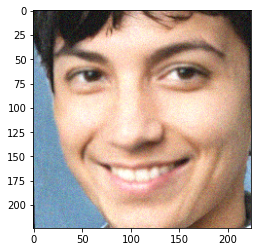

0


In [ ]:
l=13
eg = train_data1[l]
imshow(eg[0])
print(eg[1])

In [ ]:

#imshow(train_data1[0][2])

In [ ]:
train_loader = DataLoader(dataset = train_data1, batch_size=64, shuffle=True)

In [ ]:
#for i,(real, label1,fake,label2) in enumerate(train_loader):

#    images = torch.cat([real, fake])
#    labels = torch.cat([label1, label2])
#    print(len(images))
#    imshow(images[0])
#    print(type(real[5]))

#    imshow(images[64])
#    break

64


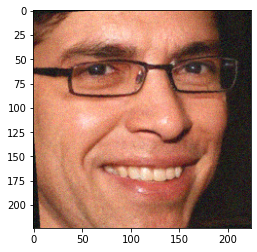

tensor(1)
<class 'torch.Tensor'>


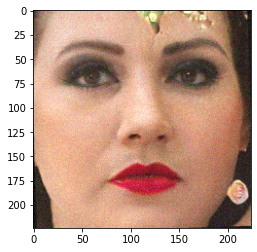

tensor(1)


In [ ]:
for i,(images, labels) in enumerate(train_loader):
    print(len(images))
    imshow(images[0])
    print(labels[0])
    print(type(images[5]))

    imshow(images[63])
    print(labels[63])
    break

# model

In [ ]:
from torch.optim import lr_scheduler
learning_rate=0.001
model=models.resnet50(pretrained=True)
in_features=model.fc.in_features
model.fc=nn.Linear(in_features,1)
lossF=nn.BCEWithLogitsLoss()
print(model.parameters())
optimizer=optim.SGD(model.parameters(),lr=learning_rate, momentum=0.5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=900, gamma=0.95)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cnn7weights/fyp_cnn_daud75_0.03945033531636.pth'))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



<generator object Module.parameters at 0x7f1d822d6bd0>


<All keys matched successfully>

In [ ]:
print(device)

cuda:0


# train model

In [ ]:
fullGraph=[]
for epoc in range(0,10):
    running_loss=0.0
    losses=[]
    for i,(images, labels) in enumerate(train_loader):

        images,labels=images.to(device),labels.to(device)
        labels=torch.unsqueeze(labels,1)
        labels=labels.float()
        optimizer.zero_grad()
        output=model(images)
        loss=lossF(output,labels)
        loss.backward()
        optimizer.step()
        exp_lr_scheduler.step()
        running_loss += loss.item()
        if i % 10 == 0:
            losses.append(running_loss)
            print('[%d, %5d] loss: %.5f' %
                (epoc + 1, i + 1, running_loss))
            running_loss = 0.0
    print('Epoch Done')
    torch.save(model.state_dict(), '/content/drive/MyDrive/cnn7weights/fyp_cnn_daud7'+str(epoc)+'_'+str(running_loss)+'.pth')
    fullGraph.append(losses)
#torch.save(model.state_dict(), '/content/drive/MyDrive/fyp_cnn_daud32_'+str(running_loss)+'.pth')
print("Training done!")


[1,     1] loss: 0.68758
[1,    11] loss: 6.78455
[1,    21] loss: 6.54120
[1,    31] loss: 6.36996
[1,    41] loss: 6.17852
[1,    51] loss: 5.96120
[1,    61] loss: 5.76692
[1,    71] loss: 5.63502
[1,    81] loss: 5.18790
[1,    91] loss: 5.02664
[1,   101] loss: 4.73980
[1,   111] loss: 4.45604
[1,   121] loss: 4.06691
[1,   131] loss: 3.75118
[1,   141] loss: 3.48535
[1,   151] loss: 3.12274
[1,   161] loss: 2.92248
[1,   171] loss: 2.63190
[1,   181] loss: 2.40183
[1,   191] loss: 2.27819
[1,   201] loss: 1.97342
[1,   211] loss: 1.88607
[1,   221] loss: 1.56559
[1,   231] loss: 1.46608
[1,   241] loss: 1.41629
[1,   251] loss: 1.35433
[1,   261] loss: 1.11861
[1,   271] loss: 1.21908
[1,   281] loss: 1.08769
[1,   291] loss: 1.08210
[1,   301] loss: 1.11061
[1,   311] loss: 1.03145
[1,   321] loss: 0.88808
[1,   331] loss: 0.78405
[1,   341] loss: 0.70661
[1,   351] loss: 0.70140
[1,   361] loss: 0.68653
[1,   371] loss: 0.63717
[1,   381] loss: 0.68491
[1,   391] loss: 0.68263


In [ ]:

for graphs in fullGraph:
    plt.plot(graphs)
    plt.show()

In [ ]:
continuousGraph = fullGraph[0]+fullGraph[1]#+fullGraph[2]#+fullGraph[3]+fullGraph[4]
plt.plot(continuousGraph)
plt.show()

In [ ]:
continuousGraph = fullGraph[1]+fullGraph[2]+fullGraph[3]+fullGraph[4]+fullGraph[5]
plt.plot(continuousGraph)
plt.show()

# Test set

In [ ]:
class TestFakeFacesDataset(Dataset):

    def __init__(self, root_dir, transform=None, label=0):
      self.root_dir=root_dir
      self.transform=transform
      self.label=label
    def __len__(self):
        return len(os.listdir(self.root_dir))
    def __getitem__(self, idx):
        label=0
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.listdir(self.root_dir)[idx]

        image = Image.open(self.root_dir+'/'+img_name)
        if self.transform is not None:
            image=self.transform(image)

        label = self.label #0=fake, 1=real
        return [image, label]

In [ ]:
#testData = TestFakeFacesDataset('/content/content/realValidation', transform = data_transf2, label=1)

testData = TestFakeFacesDataset('/content/processed_train_data/real', transform = data_transf2, label=1)

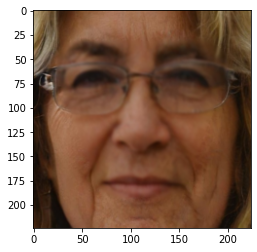

In [ ]:
imshow(testData[0][0])

In [ ]:
print(testData[0][1])

1


In [ ]:
test_loader = DataLoader(dataset = testData, batch_size=64, shuffle=True)

# Test Model

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i,(images,labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images.float())
        predicted = ((torch.squeeze(outputs)>0)*1).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct)
print(total)

14742
29037


In [ ]:
print(outputs.data)

In [ ]:
shutil.rmtree('/content/1processed/.ipynb_checkpoints')

# GETTING FRAMES FROM VIDEO

In [ ]:
vidcap = cv2.VideoCapture('/content/1.avi')
frames=[]
success,image = vidcap.read()
count=1
while success:
    frames.append(image)
    # cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file if you want
    success,image = vidcap.read()
    # print('Read a new frame: ', success)
    count += 1
print(count, " frames extracted")

120  frames extracted


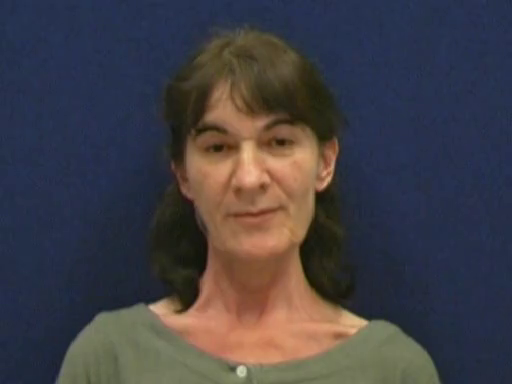

In [ ]:
cv2_imshow(frames[1])

In [ ]:
i=0
for frame in frames:
    cv2.imwrite('/content/1/'+str(i)+".jpg", frame)
    i+=1

#extract and preprocess faces from frame images

In [ ]:
!cp "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat" "/content/shape_predictor_68_face_landmarks.dat"

In [ ]:
def rect_to_bb(rect):
	# rectobject to (x,y,w,h)
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	return (x, y, w, h)

In [ ]:
def shape_to_np(shape, dtype="int"):
	coords = np.zeros((68, 2), dtype=dtype)
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# 68 landmarks to np array
	return coords

In [ ]:
def umeyama( src, dst, estimate_scale ):
    """Estimate N-D similarity transformation with or without scaling.
    Parameters
    ----------
    src : (M, N) array
        Source coordinates.
    dst : (M, N) array
        Destination coordinates.
    estimate_scale : bool
        Whether to estimate scaling factor.
    Returns
    -------
    T : (N + 1, N + 1)
        The homogeneous similarity transformation matrix. The matrix contains
        NaN values only if the problem is not well-conditioned.
    References
    ----------
    .. [1] "Least-squares estimation of transformation parameters between two
            point patterns", Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
    """

    num = src.shape[0]
    dim = src.shape[1]

    # Compute mean of src and dst.
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    # Subtract mean from src and dst.
    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    # Eq. (38).
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

In [ ]:
# mean coords of landmarks on alligned face
#used to align face when simulating deepfakes pipeline
# taken from yuezen's research paper implementation
y = np.array([
    0.106454, 0.038915, 0.0187482, 0.0344891, 0.0773906, 0.0773906, 0.0344891,
    0.0187482, 0.038915, 0.106454, 0.203352, 0.307009, 0.409805, 0.515625, 0.587326,
    0.609345, 0.628106, 0.609345, 0.587326, 0.216423, 0.178758, 0.179852, 0.231733,
    0.245099, 0.244077, 0.231733, 0.179852, 0.178758, 0.216423, 0.244077, 0.245099,
    0.780233, 0.745405, 0.727388, 0.742578, 0.727388, 0.745405, 0.780233, 0.864805,
    0.902192, 0.909281, 0.902192, 0.864805, 0.784792, 0.778746, 0.785343, 0.778746,
    0.784792, 0.824182, 0.831803, 0.824182])
x = np.array([
    0.000213256, 0.0752622, 0.18113, 0.29077, 0.393397, 0.586856, 0.689483, 0.799124,
    0.904991, 0.98004, 0.490127, 0.490127, 0.490127, 0.490127, 0.36688, 0.426036,
    0.490127, 0.554217, 0.613373, 0.121737, 0.187122, 0.265825, 0.334606, 0.260918,
    0.182743, 0.645647, 0.714428, 0.793132, 0.858516, 0.79751, 0.719335, 0.254149,
    0.340985, 0.428858, 0.490127, 0.551395, 0.639268, 0.726104, 0.642159, 0.556721,
    0.490127, 0.423532, 0.338094, 0.290379, 0.428096, 0.490127, 0.552157, 0.689874,
    0.553364, 0.490127, 0.42689])
aligned_landmarks_norm = np.stack([x, y], axis=1)

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [ ]:
positiveImages=[]
invalidNames=[]
validNames=[]
path = ('/content/2/')
count=0
batch=0
for filename in os.listdir(path):
    img = cv2.imread(path+filename) # read iamge

    rects = detector(img, 1) # get face from image
    if (len(rects)==0):
        print("invalid: "+filename)
        invalidNames.append(filename) # just to store name of images not processed
        continue
    validNames.append(filename) # just to store name of files processed
    rect = rects[0]

    # getting landmarks
    shape= predictor(img, rect)
    shape = shape_to_np(shape)
    #print(shape) #apparently coords of landmarks of face

    image_landmarks = shape[17:]
    face_rect = [image_landmarks[:,0].min(), image_landmarks[:,1].min(), image_landmarks[:,0].max(), image_landmarks[:,1].max()] #(opposite corners of rect)
    face_landmarks = image_landmarks-[image_landmarks[:,0].min(), image_landmarks[:,1].min()] # translating coords of landmarks_image to landmarks_face
    face = img[face_rect[1]:face_rect[3], face_rect[0]:face_rect[2]]

    ################################
    # align face
    ##################################


    scale = np.random.uniform(0.75,0.95)


    # upscaling the standard aligned face preset coordinates to the size of face in input image (so input image's face can be aligned
    # similar to the standard one)
    aligned_landmarks = aligned_landmarks_norm*[face.shape[1], face.shape[0]]
    aligned_landmarks_translated = aligned_landmarks+[image_landmarks[:,0].min(), image_landmarks[:,1].min()]

    # get transformation matrix to align the face
    trans_matrix_squareshape = umeyama(image_landmarks, aligned_landmarks_translated, True) # has to be square shaped for math purposes
    trans_matrix = trans_matrix_squareshape[0:2] # but we need only 2x3 matrix, so we discard 1 dummy row

    #align face
    tempimg = img.copy()
    img_aligned = cv2.warpAffine(tempimg,trans_matrix,(tempimg.shape[1], tempimg.shape[0]), borderMode=cv2.BORDER_REPLICATE)


    # get face from aligned face
    rects = detector(img_aligned, 1)
    if (len(rects)==0):
        print("invalid at check 2: "+filename)
        invalidNames.append(filename) # just to store name of images not processed
        continue
    rect= rects[0]

    # get landmarks from aligned face
    shape= predictor(img_aligned, rect)
    shape = shape_to_np(shape)
    image_landmarks = shape[17:]
    face_rect = [image_landmarks[:,0].min(), image_landmarks[:,1].min(), image_landmarks[:,0].max(), image_landmarks[:,1].max()] #(opposite corners of rect)

    new_top_left = (face_rect[0], face_rect[1])
    new_bottom_right = (face_rect[2], face_rect[3])


    # crop face region from aligned image with some random 15-25% extra area
    #################################
    h, w = img.shape[:2]
    x1, y1 = new_top_left[0], new_top_left[1]
    x2, y2 = new_bottom_right[0], new_bottom_right[1]
    delta_x = (x2 - x1) / 8
    delta_y = (y2 - y1) / 5
    delta_x = np.random.randint(delta_x, high=delta_x*1.20)
    delta_y = np.random.randint(delta_y, high=delta_y*1.20)
    x1_ = np.int(np.maximum(0, x1 - delta_x))
    x2_ = np.int(np.minimum(w-1, x2 + delta_x))
    y1_ = np.int(np.maximum(0, y1 - delta_y))
    y2_ = np.int(np.minimum(h-1, y2 + delta_y))

    ###################################

    cropped_img_aligned = img_aligned[y1_:y2_, x1_:x2_, :] # crop face region from original image with some random 15-25% extra area


    positiveImages.append(cropped_img_aligned)
    count=count+1
    print ("\r Images processed... {}".format(count), end="")

    if(len(positiveImages)%100==99):
        for index in range(len(positiveImages)):
            cv2.imwrite('/content/2processed/'+validNames[index], positiveImages[index])
        positiveImages=[]
        batch = batch+1
        print("\nBatch Cleared "+str(batch)+"\n")

 Images processed... 99
Batch Cleared 1

 Images processed... 119

In [ ]:
if(len(positiveImages)>0):
    for index in range(len(positiveImages)):
        cv2.imwrite('/content/2processed/'+validNames[index], positiveImages[index])
    negImages=[]
    positiveImages=[]
    invalidNames=[]
    validNames=[]

In [ ]:
print(len(os.listdir('/content/2processed/')))

99


In [ ]:
!zip -r -j '/content/3processed.zip' '/content/3processed'

# test on videos

In [ ]:

data_transf3 = transforms.Compose([
        transforms.Resize((224 ,224)),
        transforms.ToTensor()])

In [ ]:
dir = '/content/content/realValidation/'
totalVideos=len(os.listdir(dir))
correctPredictedVideos=0
truthLabel=0
for video in os.listdir(dir):
    testData = TestFakeFacesDataset(dir+video, transform = data_transf3, label=1)
    test_loader = DataLoader(dataset = testData, batch_size=64, shuffle=True)

    correct = 0
    total = 0
    with torch.no_grad():
        for i,(images,labels) in enumerate(test_loader):

            images, labels = images.to(device), labels.to(device)



            outputs = model(images.float())
            predicted = ((torch.squeeze(outputs)>0)*1).float()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(correct)
    #print(total)
    if(correct>(total-correct)):
        print(correct)
        print(total)
        print(video + ":   correct\n\n")
        correctPredictedVideos += 1
    else:
        print(correct)
        print(total)
        print(video + ":   wrong!!!\n\n")


print("\n\nTotal Videos: "+str(totalVideos))
print("Correct predicted: "+str(correctPredictedVideos))

64
135
1sx109:   wrong!!!


65
117
10si1909:   correct


48
109
6sx379:   wrong!!!


67
126
3sx289:   correct


39
72
8si1279:   correct


75
144
7sx199:   correct


62
119
2sa1:   correct


52
103
5sa2:   correct


45
97
9sx19:   wrong!!!


113
216
4si649:   correct




Total Videos: 10
Correct predicted: 7


In [ ]:
print(correctPredictedVideos/totalVideos)

0.7


In [ ]:
print(outputs)

tensor([[ 0.4755],
        [-0.5865],
        [-0.1506],
        [-1.0324],
        [ 1.5600],
        [-1.2557],
        [-0.1328],
        [ 0.5672],
        [-1.4134],
        [ 0.2139],
        [ 3.0948],
        [ 2.2414],
        [-1.4163],
        [-1.7168],
        [-0.0285],
        [ 0.8056],
        [ 1.8021],
        [ 2.0198],
        [-0.7362],
        [ 0.7266],
        [ 0.4541],
        [-2.6116],
        [ 0.1293],
        [-1.3273]], device='cuda:0')


In [ ]:
print((torch.squeeze(outputs)>0.5)*1)

tensor([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')


In [ ]:
!unzip '/content/3processed.zip' -d '/content/3processed/'

Archive:  /content/3processed.zip
  inflating: /content/3processed/Leonardo-Dicaprio-in-Titanic-2-1.jpg  
  inflating: /content/3processed/78226_USA20170607FILMTHEMUMMYREUTERS_1588742767110.jpg  
  inflating: /content/3processed/4159.jpg  
  inflating: /content/3processed/176-tom-cruise.jpg  
  inflating: /content/3processed/378_v9_bd.jpg  
  inflating: /content/3processed/Leonardo_Dicaprio_Cannes_2019.jpg  
  inflating: /content/3processed/George_Clooney.jpg  
  inflating: /content/3processed/1200px-Tom_Cruise_in_London,_2015_(cropped).jpg  
  inflating: /content/3processed/brad-pitt.jpg  
  inflating: /content/3processed/Brad-Pitt-2.jpg  


# Discarded code

In [ ]:
# use either real or fake version of image
class FakeFacesDataset(Dataset):

    def __init__(self, root_dir, transform=None):
      self.root_dir=root_dir
      self.transform=transform
    def __len__(self):
        return len(os.listdir(self.root_dir+'/real/'))
    def __getitem__(self, idx):
        label=0
        if torch.is_tensor(idx):
            idx = idx.tolist()

        probability = np.random.uniform(low=0.0, high=1.0)
        #print(probability)
        img_name = os.listdir(self.root_dir+'/real/')[idx]
        if (probability<0.5): # real
            image = Image.open(self.root_dir+'/real/'+img_name)
            label=1

        else: #fake
            img_name2 = img_name.replace('real', 'fake')
            image = Image.open(self.root_dir+'/fake/'+img_name2)
            label=0

        if self.transform is not None:
            image=self.transform(image)

        return [image, label]